# Statistics : Examples from Epidemiology

## Group and Individuals : The Ecological Fallacy

<img src="Images/nobelcho.jpeg" style="width: 500px;"/>

*Figure: Correlation between Countries' Annual Per Capita Chocolate Consumption and the Number of Nobel Laureates per 10 Million Population (Messerli, 2012)*

Can we infer any casualty from this result? 
Does per capita chocolate consumption really increase the probability of winning a nobel prize?
Similar claims can be seen in everyday life such as newspaper, TV shows or even in scientific literature. 

For example, a newspaper article asserts that an intentional manipulation is being made on public surveys, based on a correlation between the response rate and the pro-government response.
<img src="Images/newdaily.png" style="width: 800px;"/>
*Figure: A correlation between response rate and pro-government response is observed*

Is this a proper reasoning? Can this data be considered as a definitive evidence for an intentional manipulation?
What these analyses have in common is that they computed the correlation between groups rather than between individuals.
The first example computed the correlation of country level variables which are aggregates of individuals who live in those countries.
The second example computed the correlation of date level variables which are aggregates of individuals who responsed to each survey.

The following code demonstrates graphically why such correlations can be very misleading.
The first code is a counterexample for the frist example.

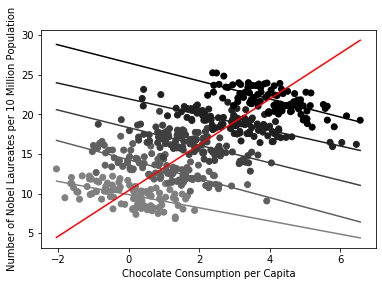

In [46]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import colour as colour

# function generating country
def datagen(n_country, n_sample):
    
    data = pd.DataFrame(columns=['get_nobel', 'choco_per_capita', 'country'])
    for i in range(n_country):
        choco_per_capita = np.random.normal(loc=i, scale=1, size=n_sample)
        e = np.random.normal(loc=0, scale=1, size=n_sample)
        get_nobel = -1 * choco_per_capita + e + i * 4 + 10
        data_sub = pd.DataFrame({'get_nobel':get_nobel, 'choco_per_capita':choco_per_capita, 'country':i})
        data = data.append(data_sub)
        
    return data

# define country and sample size
n_country, n_sample = 5, 100

# generate data for each country
data = datagen(n_country, n_sample)

# define colormap
colors = pd.Series(colour.Color('grey').range_to(colour.Color('black'), n_country)).astype('str')

# draw scatter plot and regression line
plt.scatter(data['choco_per_capita'], data['get_nobel'], color=colors[data['country']])
for i in range(n_country):
    data_sub = data[data['country'] == i]
    m, b = np.polyfit(data_sub['choco_per_capita'], data_sub['get_nobel'], 1)
    plt.plot(np.linspace(data['choco_per_capita'].min(), data['choco_per_capita'].max(), 100)
                         , m * np.linspace(data['choco_per_capita'].min(), data['choco_per_capita'].max(), 100) + b, 
                         color=colors[i])

plt.xlabel('Chocolate Consumption per Capita')
plt.ylabel('Number of Nobel Laureates per 10 Million Population')

# aggregate data and plot their means
data_agg = data.groupby('country').mean()
m, b = np.polyfit(data_agg['choco_per_capita'], data_agg['get_nobel'], 1)
plt.plot(np.linspace(data['choco_per_capita'].min(), data['choco_per_capita'].max(), 100)
                         , m * np.linspace(data['choco_per_capita'].min(), data['choco_per_capita'].max(), 100) + b, 
                         color='red')

plt.show()

### From the above figure, it is clear that chocolate consumption reduces the number of nobel prize laureates, however...
When regressed in a country-wise manner, the direction of association is reversed.

Now let's examine the second example.
Before the code, I will explain some statistical background knowledge why the arthors of the article made such claims.

<img src='Images/newdaily1.png' style="width: 600px"/>

*Figure : correlation between response rate and pro-government response*

If someone is introducing an intentional bias to the survey, for example including the same number of additional pro-government respondents to the survey, such correlation can appear because as less and less people respond to the survey, the effect of pro-government respondents will increase.

The following code demonstrates this situation.

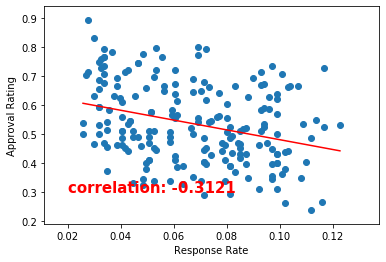

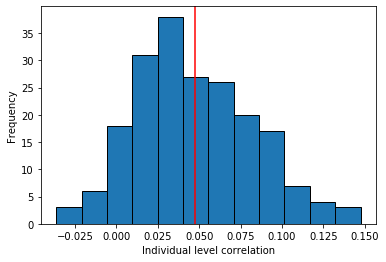

In [139]:
# parameters
n_survey = 200
n_biased = 10
n_unbiased = 1000

# dataframe storing rr and ar
rr_vs_ar = pd.DataFrame(columns = ['rr','ar'])

# Series stroing per survey individual correlation
corrs = pd.Series([])

# iterate through number of surveys
for i in range(n_survey):
    
    # sample parameter
    p_progov = np.random.uniform(low=0.2,high=0.7)
    p_respond = np.random.uniform(low=0.02, high=0.1)    
    
    # sample data
    sample_unbiased = pd.DataFrame({'pro_gov':np.random.binomial(n=1,p=p_progov,size=n_unbiased),
                                   'respond':np.random.binomial(n=1,p=p_respond,size=n_unbiased)})
    sample_biased = pd.DataFrame({'pro_gov':np.ones(n_biased), 'respond':np.ones(n_biased)})
    data = pd.concat([sample_biased, sample_unbiased], axis=0)
    
    # compute response rate and approval rating
    data_respond = data[data['respond']==1]
    rr, ar = data_respond.shape[0]/data.shape[0], data_respond['pro_gov'].sum()/data_respond.shape[0]
    
    # append to rr_vs_ar
    rr_vs_ar = rr_vs_ar.append(pd.DataFrame({'rr':[rr], 'ar':[ar]})) 
    
    # compute correlation
    corrs = corrs.append(pd.Series([np.corrcoef(data['pro_gov'], data['respond'])[0,1]]))
    

plt.scatter(rr_vs_ar['rr'], rr_vs_ar['ar'])

# draw regression line
m, b = np.polyfit(rr_vs_ar['rr'], rr_vs_ar['ar'], 1)
plt.plot(np.linspace(rr_vs_ar['rr'].min(), rr_vs_ar['rr'].max(), 100)
                         , m * np.linspace(rr_vs_ar['rr'].min(), rr_vs_ar['rr'].max(), 100) + b, 
                         color='red')

plt.xlabel('Response Rate')
plt.ylabel('Approval Rating')
plt.text(x=0.02, y=0.3,
         s='correlation: '+ '%.4g' % (np.corrcoef(rr_vs_ar['rr'], rr_vs_ar['ar'])[0,1]),
        fontsize=15, color='red', fontweight='bold')
plt.show()

# individual level correlation
plt.hist(corrs, bins='auto', edgecolor='black')
plt.xlabel('Individual level correlation')
plt.ylabel('Frequency')
plt.axvline(corrs.mean(),color='red')
plt.show()



We observe what we expected.
Larger the response rate (x-axis) , lower the approval rating (y-axis).
Therefore, it might be reasonable to think that such correlation is an evidence for a intentional manipulation.

However, the following code shows that such correlation can arise without any intentional manipulation when there is a correlation structure between the response rate and approval rating itself.
In this case, a possible sociological explanation is that _politicophobia_ plays a significant role on survey results.
Alternatively, purely random seasonal flunctuation can also introduce such events.

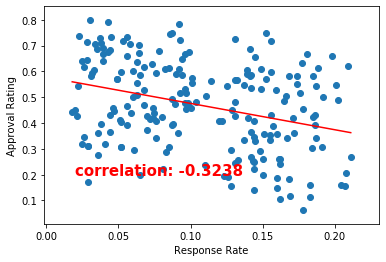

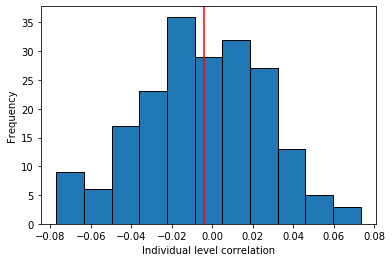

In [142]:
# parameters
n_survey = 200
n_biased = 100
n_unbiased = 1000

# dataframe storing rr and ar
rr_vs_ar = pd.DataFrame(columns = ['rr','ar'])

# Series stroing per survey individual correlation
corrs = pd.Series([])

# iterate through number of surveys
for i in range(n_survey):
    
    # possible correlation structure
    dp1, dp2 = np.random.multivariate_normal(mean=[0,0], cov=[[1,0.9],[0.9,1]], size=1).T
    
    # sample parameter
    p_progov = np.random.uniform(low=0.2,high=0.7) + np.clip(a=dp1[0], a_min=-0.1, a_max=0.1)
    p_respond = np.random.uniform(low=0.02, high=0.1) - np.clip(a=dp2[0], a_min=-0.1, a_max=0)
    
    # sample data
    sample_unbiased = pd.DataFrame({'pro_gov':np.random.binomial(n=1,p=p_progov,size=n_unbiased),
                                   'respond':np.random.binomial(n=1,p=p_respond,size=n_unbiased)})
    data = sample_unbiased
    
    # compute response rate and approval rating
    data_respond = data[data['respond']==1]
    rr, ar = data_respond.shape[0]/data.shape[0], data_respond['pro_gov'].sum()/data_respond.shape[0]
    
    # append to rr_vs_ar
    rr_vs_ar = rr_vs_ar.append(pd.DataFrame({'rr':[rr], 'ar':[ar]})) 
    
    # compute correlation
    corrs = corrs.append(pd.Series([np.corrcoef(data['pro_gov'], data['respond'])[0,1]]))
    

plt.scatter(rr_vs_ar['rr'], rr_vs_ar['ar'])

# draw regression line
m, b = np.polyfit(rr_vs_ar['rr'], rr_vs_ar['ar'], 1)
plt.plot(np.linspace(rr_vs_ar['rr'].min(), rr_vs_ar['rr'].max(), 100)
                         , m * np.linspace(rr_vs_ar['rr'].min(), rr_vs_ar['rr'].max(), 100) + b, 
                         color='red')

plt.xlabel('Response Rate')
plt.ylabel('Approval Rating')
plt.text(x=0.02, y=0.2,
         s='correlation: '+ '%.4g' % (np.corrcoef(rr_vs_ar['rr'], rr_vs_ar['ar'])[0,1]),
        fontsize=15, color='red', fontweight='bold')

plt.show()

# individual level correlation
plt.hist(corrs, bins='auto', edgecolor='black')
plt.xlabel('Individual level correlation')
plt.ylabel('Frequency')
plt.axvline(corrs.mean(),color='red')
plt.show()



### Although we observe a considerably large correlation at the survey level, individual correlation is fairly close to zero.